# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [53]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [54]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

rncp.head()

,Categorie,text_certifications
0,1,Responsable de chantiers de bûcheronnage manue...
1,1,Responsable de chantiers de bûcheronnage manue...
2,1,Travaux forestiers
3,1,Forêt
4,1,Forêt


In [55]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [56]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [57]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [58]:
# split the data in training and test sets
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [59]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 1
texts_reduced = train_texts[0::k]
labels_reduced = train_labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 75449


## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [21]:
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git >nul 2>&1

In [22]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 2.0 MB/s eta 0:00:00
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
   ---------------------------------------- 0.0/269.5 kB ? eta -:--:--
   ---------------------------------------- 269.5/269.5 kB 5.5 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [71]:
# Imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<div class='alert alert-block alert-info'>
            Code:</div>

In [73]:
# Look at the data and apply the appropriate pre-processing

def preprocess_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove everything except alphanumeric characters and diacritics
    text = re.sub(r'[^\w\sÀ-ÿ]', ' ', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('french'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize words (reduce them to their root form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Test the function
for texts in [train_texts[:5], test_texts[:5]]:
    for text in texts:
        print(text)
        print(preprocess_text(text))
    print()

Architecte d'interieur/designer
['architecte', 'interieur', 'designer']
Ingénierie Nucléaire
['ingénierie', 'nucléaire']
Métiers du Multimédia et de l’Internet : Développement web et dispositifs interactifs
['métiers', 'multimédia', 'internet', 'développement', 'web', 'dispositifs', 'interactifs']
STAPS : Ingénierie et ergonomie de l'activité physique (IEAP)(fiche nationale)
['staps', 'ingénierie', 'ergonomie', 'activité', 'physique', 'ieap', 'fiche', 'nationale']
Programme TEMA (Innovation & Digital Management), visé par le Ministère de l’Enseignement Supérieur et de la Recherche
['programme', 'tema', 'innovation', 'digital', 'management', 'visé', 'ministère', 'enseignement', 'supérieur', 'recherche']

Domaine : Sciences Technologies Santé Mention : Maintenance des systèmes pluritechniques - Spécialité : Management des services de maintenance
['domaine', 'science', 'technology', 'santé', 'mention', 'maintenance', 'systèmes', 'pluritechniques', 'spécialité', 'management', 'service', 'm

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [79]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    words = []
    for text in texts:
        text = preprocess_text(text)
        words += text
    vocabularySet = set(words)
    
    return vocabularySet


In [82]:
vocabulary = count_words(texts_reduced)

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

[[ 503  101   81   15   19   22   31  376   15   59  840   76   54  112
    21   79]
 [ 272  140    1   11    5   21   18   55    2   23  609   17   24   23
     9   72]
 [ 158    5   76    0    1    1    0  221   14    1  168   11   11  103
     4    1]
 [  21    6    0   47   47   44   25    0    0   20   67    7   24    0
     0   21]
 [  27    2    1   45   51   49   28    0    2    4   34    2   28    2
     6   11]
 [  36    9    9   41   40  121   44    7    9   31  116    6   20   21
    26   32]
 [  37    3    0   29   39   52   40    1    8   25  337    8   56    3
     0  129]
 [ 333   51   64    0    0    3    1  529   11    0  707   51   37  400
     9  110]
 [  27    3   29    0    1    6    2   18   45    0   29    1   35   33
    15    2]
 [ 115    9    0   19   19   18   22   26    1  163  250   86   18    7
     0   41]
 [ 368   99   26    8    3   20   45  518    6   50 2101   92   30  154
    22  322]
 [ 167    6    5    2    2   11    8  182    1   84  306   52   3

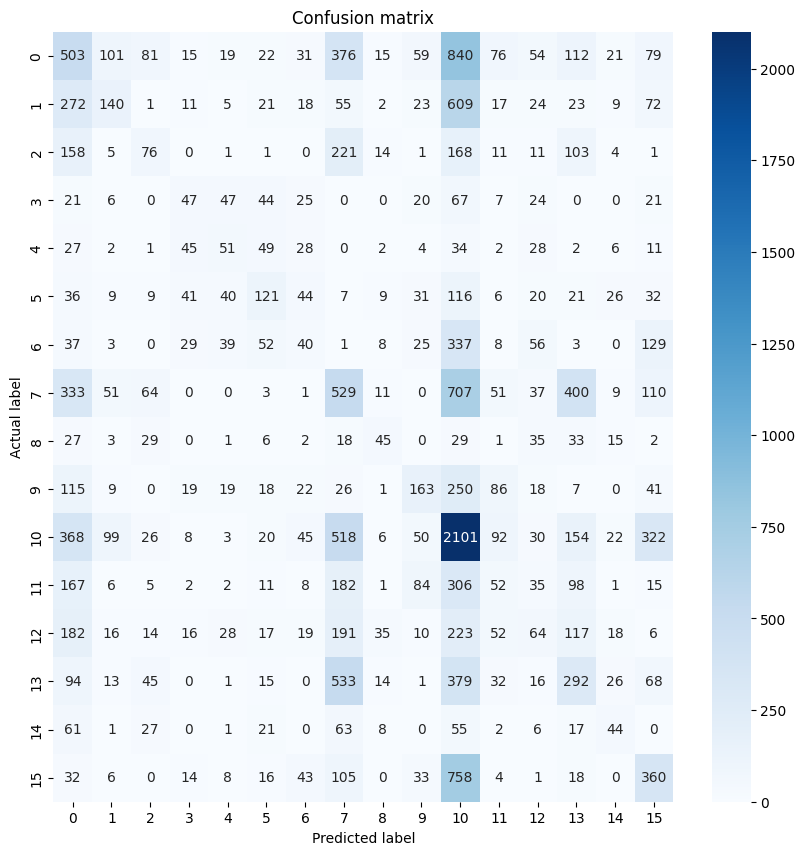

In [89]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Assume train_texts and test_texts are your training and test data
# And train_labels and test_labels are the corresponding labels

# CountVectorizer
vectorizer = CountVectorizer(vocabulary=vocabulary)
X_train = vectorizer.fit_transform(texts_reduced)
X_test = vectorizer.transform(test_texts)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, train_labels)

predictions = model.predict(X_test)
print(confusion_matrix(test_labels, predictions))

import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

[[ 606   71   73   17   21   15   34  397   14   55  778   53   46  120
    20   84]
 [ 289  148    1   14    5   15   18   71    2   26  565   12   19   19
     8   90]
 [ 162    4   84    0    1    1    0  224   13    2  146    9   10  114
     3    2]
 [  22    6    0   54   41   42   26    1    0   24   63    8   27    0
     0   15]
 [  26    0    1   48   64   43   24    0    1    5   35    2   29    0
     6    8]
 [  39    7    8   36   36  133   41    7    7   31  114    7   29   19
    24   30]
 [  42    3    0   30   41   48   40    1    7   27  317   10   53    4
     0  144]
 [ 335   48   62    0    1    3    1  611    5    0  658   50   31  393
     6  102]
 [  27    6   25    0    0    6    1   21   38    0   33    1   34   38
    15    1]
 [ 130    4    0   20   18   16   34   24    2  169  236   76   13   10
     0   42]
 [ 385   96   30    6    4   15   46  575    2   51 2063   93   14  154
    15  315]
 [ 184    5    5    3    1   11   15  212    0   79  267   54   3

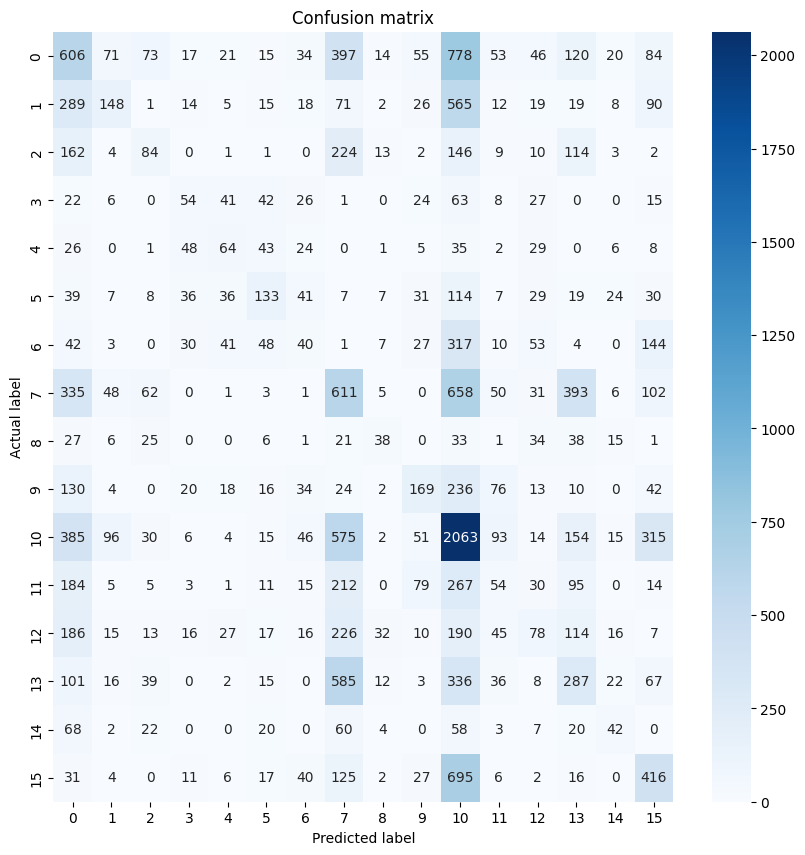

In [90]:
# TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary)
X_train = vectorizer.fit_transform(texts_reduced)
X_test = vectorizer.transform(test_texts)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, train_labels)

predictions = model.predict(X_test)
print(confusion_matrix(test_labels, predictions))

import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [88]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

# Number of topics
n_topics = 300

# TruncatedSVD
svd = TruncatedSVD(n_components=n_topics)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

model = LogisticRegression()    
model.fit(X_train_svd, train_labels)

predictions = model.predict(X_test_svd)
print(confusion_matrix(test_labels, predictions))

# LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)

model = LogisticRegression()
model.fit(X_train_lda, train_labels)

predictions = model.predict(X_test_lda)
print(confusion_matrix(test_labels, predictions))

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 627   51   67   13   22   29   27  345    9   42  869   62   26  111
    14   90]
 [ 273  128    0   12    5   20   21   52    2   23  632    7   13   25
     6   83]
 [ 142    3   83    0    2    1    0  200    7    2  204   12    7  106
     3    3]
 [  33    5    0   44   31   35   10    0    0   23   90    7   35    0
     0   16]
 [  42    0    1   19   50   32    2    0    2    4   83    1   43    2
     2    9]
 [  51    4    3   23   24   81   18    9    4   18  223    8   38   18
    17   29]
 [  47    3    0   14   28   45   29    2    4   19  355   11   73    3
     0  134]
 [ 348   38   57    0    1    4    1  613    1    0  758   34   15  330
     7   99]
 [  49    2   20    0    3    5    0    4   27    0   69    1   23   30
    12    1]
 [ 145    3    0   18   14   22   25   24    1  130  310   48   10   16
     0   28]
 [ 353   76   28    4    6   22   40  491    1   45 2262   67   15  163
    12  279]
 [ 189    6   11    4    2   10   15  180    0   53  320   66   1

KeyboardInterrupt: 

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [ ]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = ...
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = ...
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = ...                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = ...
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                ...
                ...
    return M  

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension


<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = ... # Indexes of words in the sentence obtained thanks to the vocabulary
        sentrep = ... # Embeddings of words in the sentence, aggregated thanks to the function
        representations.append(sentrep)
    representations = np.array(representations)    
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Obtain document representations, apply the classifier


## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))
model.build_vocab_from_freq(word_counts)

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = [...]

In [ ]:
model.train(preprocessed_corpus, total_examples=..., epochs=30, report_delay=1)

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 